In [3]:
import datetime
import dateutil.parser
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import scipy
import seaborn as sns
import talib
import time

from statsmodels.tsa.stattools import coint
from tqdm.notebook import tqdm
from urllib.parse import urlencode

plt.rcParams["figure.figsize"] = (20, 10)

In [ ]:

def fetch_ohlc(sym, **kwargs):
    # https://docs.bitmex.com/api-explorer/get-trade-bucketed    
    query = {'symbol': sym, 'binSize': '1m', 'count': 1000, 'reverse': 'true'} | kwargs
    r = requests.get(f'https://www.bitmex.com/api/v1/trade/bucketed?{urlencode(query)}')
    if int(r.headers['x-ratelimit-remaining']) < 10:
        wait = int(r.headers['x-ratelimit-reset']) - time.time()
        time.sleep(wait + 5)
    return r.json()


def data_ohlc(sym, count=5000):
    rows = fetch_ohlc(sym, endTime=datetime.date.today().isoformat())
    
    while len(rows) < count:
        end_time = dateutil.parser.isoparse(rows[-1]['timestamp'])
        end_time -= datetime.timedelta(minutes=1)
        end_iso = end_time.replace(tzinfo=None).isoformat() + 'Z'
        data = fetch_ohlc(sym, endTime=end_iso)
        if len(data) == 0:
            break
        rows.extend(data)
        
    cf = pd.DataFrame(rows).sort_values('timestamp')
    return cf.drop_duplicates().reset_index(drop=True)


In [4]:
C = fetch_ohlc('ETHUSD')
C[0]

{'timestamp': '2025-11-07T17:50:00.000Z',
 'symbol': 'ETHUSD',
 'open': 3381.65,
 'high': 3378.4,
 'low': 3377.34,
 'close': 3378.4,
 'trades': 3,
 'volume': 43,
 'vwap': 3377.7,
 'lastSize': 1,
 'turnover': 14524075,
 'homeNotional': 4.381102453749551,
 'foreignNotional': 14798.013404377676}

In [5]:
syms = ['XBTUSD', 'XBTH26']
times = set()
frames = []

for sym in tqdm(syms):
    cf = data_ohlc(sym)
    xf = cf[['timestamp', 'close']]
    xf.columns = ['time', sym]
    times |= set(xf['time'])
    frames.append(xf)
    
df = pd.DataFrame(sorted(times), columns=['time'])

for xf in frames:
    df = df.merge(xf, on='time', how='left')
    
df

  0%|          | 0/2 [00:00<?, ?it/s]

,time,XBTUSD,XBTH26
0,2025-11-03T12:41:00.000Z,107863.2,110314.5
1,2025-11-03T12:42:00.000Z,107843.9,110314.5
2,2025-11-03T12:43:00.000Z,107847.6,110314.5
3,2025-11-03T12:44:00.000Z,107864.4,110118.5
4,2025-11-03T12:45:00.000Z,107780.0,110118.5
...,...,...,...
4995,2025-11-06T23:56:00.000Z,101248.0,103242.5
4996,2025-11-06T23:57:00.000Z,101231.6,103254.0
4997,2025-11-06T23:58:00.000Z,101269.6,103233.0
4998,2025-11-06T23:59:00.000Z,101228.0,103233.0


In [6]:
y0 = df['XBTUSD']
y1 = df['XBTH26']

tstat, pvalue, _ = coint(y0, y1, trend='ct')

# if pvalue < 0.05 then (y0, y1) is cointegrated
pvalue

4.761479268628486e-17

In [7]:
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts

y1c = sm.add_constant(y1)

model = sm.OLS(y0, y1c)
results = model.fit()

In [8]:
const = results.params[0]
beta = results.params[1]

const, beta

(3588.752446886524, 0.9466276028484728)

<Axes: >

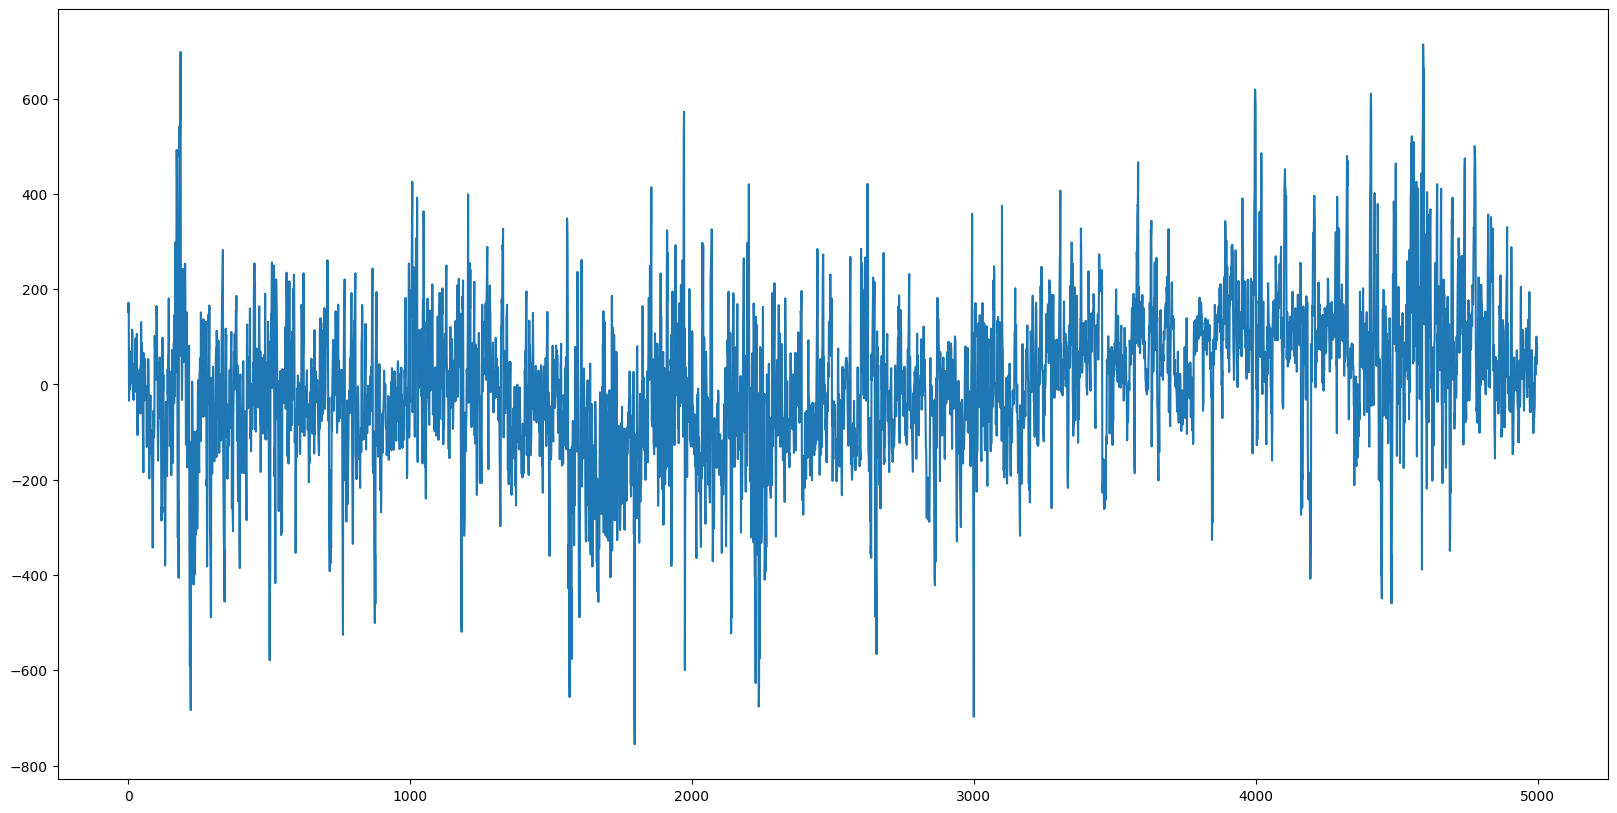

In [10]:
(const + beta * y1 - y0).plot()